In [2]:
import os
os.getcwd()

'/Users/jeongseok/Documents/GitHub/prop-tech/Real estate Analysis'

In [5]:
# 모듈, 경로 설정
import pandas as pd
import pydeck as pdk
import geopandas as gpda
import config
import json
import requests
import sys
import folium

path = "/Users/jeongseok/Documents/GitHub/aide-analysis"
sys.path.append(path)

path2 = "C:\github/prop-tech/"
sys.path.append(path2)
from src.bigquery import bigquery_client, bigquery
from src.visualization import Pydeck
pydeck = Pydeck()
bq = bigquery_client
from core.config import Config
config = Config()


OSError: Could not find lib c or load any of its variants [].

In [ ]:
# 시각화 한글패치
import os
import matplotlib.pyplot as plt

if os.name =='posix':

    plt.rc('font', family = 'AppleGothic')

else:

    plt.rc('font', family = 'Malgun Gothic')

In [2]:
# 1인가구 데이터 불러오기
sql = f"""
SELECT sigunguCode, hdongName, ROUND(SUM(sedae1/totalSedae),3) AS sedae1Ratio
FROM aide.population_sedae
WHERE sidoCode ='11' 
      AND sigunguCode NOT LIKE '%000'
      AND date = (SELECT MAX(date) FROM aide.population_sedae)
GROUP BY sigunguCode, hdongName
ORDER BY sedae1Ratio DESC
"""
df = bq.query(sql).to_dataframe()

In [3]:
# Vworld 시군구 경계 API 호출
def gl(sig_cd):
    # 엔드포인트
    endpoint = "http://api.vworld.kr/req/data"

    # API 파라미터
    service = "data"
    request = "GetFeature"

    # 행정동 경계
    data = "LT_C_ADSIGG_INFO"

    # 요청 파라미터
    key = config.OPEN_API["vworld"]
    page = 1
    size = 1000
    
    attrFilter = f"sig_cd:like:{11}"
    url = f"{endpoint}?service={service}&request={request}&data={data}&key={key}&attrFilter={attrFilter}&page={page}&size={size}"

    # 요청 결과
    res = json.loads(requests.get(url).text)

    # GeoJson 생성
    featureCollection = {"type": "FeatureCollection"}
    features = []
    while True:
        # 요청 URL
        url = f"{endpoint}?service={service}&request={request}&data={data}&key={key}&attrFilter={attrFilter}&page={page}&size={size}"
        # 요청 결과
        res = json.loads(requests.get(url).text)
        # GeoJson 추가
        features = features + res["response"]["result"]["featureCollection"]["features"]
        # 페이지
        page_current = int(res["response"]["page"]["current"])
        page_total = int(res["response"]["page"]["total"])
        page += 1
        if page_current == page_total:
            break
    featureCollection["features"] = features
    geo = featureCollection
    return geo
geo = gl(11)

In [4]:
from mapboxgl.viz import *
from mapboxgl.utils import create_color_stops

## 1인 가구 비율이 가장 높은 시군구 시각화

In [5]:
# params
icon = ['star','flag']
tiles = ['cartodbpositron', 'Stamen Toner', 'OpenStreetMap']
center = [37.5150660594, 127.0180350423]

# Base Map
m = folium.Map(
    location = [center[0], center[1]],
    zoom_start = 14,
    tiles = tiles[0]
)

# Choropleth
folium.Choropleth(
    geo_data=geo,
    data=df,
    columns=["sigunguCode", "sedae1Ratio"],
    key_on="properties.sig_cd",
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="1인가구 비율",
).add_to(m)


# 오픈스트리트맵 api호출 
key = "7c352c8ff1244dd8b732e349e0b0fe8d"
url = f"https://a.tile.thunderforest.com/transport/{{z}}/{{x}}/{{y}}.png?apikey={key}"
tile_layer = folium.TileLayer(tiles = url, attr ='생각하는 마리오네트',overlay = True, control = True)
tile_layer.add_to(m)


m


관악구가 1인가구 비율이 가장 높은것으로 보인다.

## 관악구의 시계열을 통한 가구비율 변화 시각화

In [6]:
# 1인가구 데이터 불러오기
sql = f"""
SELECT  sigunguCode, 
        hdongName,
        ROUND(SUM(sedae1/totalSedae),3) AS sedae1Ratio, 
        ROUND(SUM(sedae2/totalSedae),3) AS sedae2Ratio,
        ROUND(SUM(sedae3/totalSedae),3) AS sedae3Ratio,
        ROUND(SUM(sedae4/totalSedae),3) AS sedae4Ratio,
FROM aide.population_sedae
WHERE sidoCode ='11' 
      AND sigunguCode NOT LIKE '%000'
      AND date = (SELECT MAX(date) FROM aide.population_sedae)
      AND sigunguCode ='11620'
GROUP BY sigunguCode, hdongName
ORDER BY sedae1Ratio DESC
"""
df = bq.query(sql).to_dataframe()
df = df.rename(columns = {'sigunguCode':'시군구코드', 'hdongName':'행정동명','sedae1Ratio':'1인가구비율','sedae2Ratio':'2인가구비율','sedae3Ratio':'3인가구비율','sedae4Ratio':'4인가구비율'})
df

In [9]:
# 1인가구 데이터 불러오기
sql = f"""
SELECT  sigunguCode, 
        hdongName,
        year,
        round(AVG(sedae1),3) AS sedae1Ratio, 
        round(AVG(sedae2),3) AS sedae2Ratio,
        round(AVG(sedae3),3) AS sedae3Ratio,
        round(AVG(sedae4),3) AS sedae4Ratio,
FROM aide.population_sedae
WHERE sidoCode ='11' 
      AND sigunguCode NOT LIKE '%000'
      AND sigunguCode ='11620'
GROUP BY sigunguCode, hdongName, year
ORDER BY year
"""
df = bq.query(sql).to_dataframe()

In [10]:
df

,sigunguCode,hdongName,year,sedae1Ratio,sedae2Ratio,sedae3Ratio,sedae4Ratio
0,11620,서울특별시 관악구,2008,106930.083,41754.917,38340.083,40122.917
1,11620,서울특별시 관악구,2009,109686.667,42438.333,38096.917,39157.750
2,11620,서울특별시 관악구,2010,112703.667,43174.833,37586.917,38035.583
3,11620,서울특별시 관악구,2011,117303.667,43947.667,37290.167,37055.500
4,11620,서울특별시 관악구,2012,118350.583,44401.667,37140.917,36127.500
5,11620,서울특별시 관악구,2013,120100.167,45152.667,36792.667,35025.417
6,11620,서울특별시 관악구,2014,121668.667,45871.083,36423.833,33767.917
7,11620,서울특별시 관악구,2015,123443.750,46368.500,36241.083,32721.250
8,11620,서울특별시 관악구,2016,127109.750,46603.167,35781.917,31608.083
9,11620,서울특별시 관악구,2017,131797.917,47121.083,35276.417,30171.917


In [11]:
# 필요한 컬럼만 가져오기
df = df[['year','sedae1Ratio','sedae2Ratio','sedae3Ratio','sedae4Ratio']]

# 데이터 형태 바꾸기
df = pd.melt(df,
       id_vars = 'year',
       value_vars = ['sedae1Ratio','sedae2Ratio','sedae3Ratio', 'sedae4Ratio'])

# 컬럼명 변경
df = df.rename(columns = {'year':'년도','variable':'가구타입','value':'가구수'})

In [15]:
df

,년도,가구타입,가구수
0,2008,sedae1Ratio,106930.083
1,2009,sedae1Ratio,109686.667
2,2010,sedae1Ratio,112703.667
3,2011,sedae1Ratio,117303.667
4,2012,sedae1Ratio,118350.583
5,2013,sedae1Ratio,120100.167
6,2014,sedae1Ratio,121668.667
7,2015,sedae1Ratio,123443.750
8,2016,sedae1Ratio,127109.750
9,2017,sedae1Ratio,131797.917


In [17]:
# 가구비율의 변화를 보기 위해 비율 값 지수화
df1 = df[df['가구타입']=='sedae1Ratio']
df2 = df[df['가구타입']=='sedae2Ratio']
df3 = df[df['가구타입']=='sedae3Ratio']
df4 = df[df['가구타입']=='sedae4Ratio']


df1['가구수'] =df1['가구수'].apply(lambda x: (x/df1['가구수'].iloc[0])-1)
df2['가구수'] =df2['가구수'].apply(lambda x: (x/df2['가구수'].iloc[0])-1)
df3['가구수'] =df3['가구수'].apply(lambda x: (x/df3['가구수'].iloc[0])-1)
df4['가구수'] =df4['가구수'].apply(lambda x: (x/df4['가구수'].iloc[0])-1)


C:\Users\JEONGS~1\AppData\Local\Temp/ipykernel_23096/2415374177.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['가구수'] =df1['가구수'].apply(lambda x: (x/df1['가구수'].iloc[0])-1)
C:\Users\JEONGS~1\AppData\Local\Temp/ipykernel_23096/2415374177.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['가구수'] =df2['가구수'].apply(lambda x: (x/df2['가구수'].iloc[0])-1)
C:\Users\JEONGS~1\AppData\Local\Temp/ipykernel_23096/2415374177.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

C:\Users\jeongseokLim\anaconda3\envs\aide\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


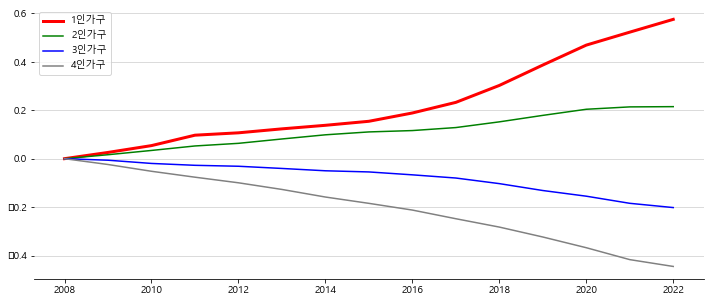

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax =plt.subplots(figsize = (12,5))
ax.plot( df1['년도'],df1['가구수'], label = '1인가구', color ='red', linewidth = 3)
ax.plot( df2['년도'],df2['가구수'], label = '2인가구', color = 'green')
ax.plot( df3['년도'],df3['가구수'], label = '3인가구', color = 'blue')
ax.plot( df4['년도'],df4['가구수'], label = '4인가구', color = 'gray')

# 그리드 추가
ax.grid(axis="y", c="lightgray") # "axis = 'x'" 는 x축 세로선 grid생성

# 필요없는 선 제거
ax.spines[["left", "top", "right"]].set_visible(False)
ax.legend()

1인가구가 증가하는것이 명확하게 보인다. 그렇다면 어디서 관악구로 오는것일까 그 중, 서울시내에서 관악구로 오는 사람들을 살펴보자

In [20]:
from src.bigquery import BigqueryHandler
from src.visualization import Pydeck
pydeck = Pydeck()
BH = BigqueryHandler()
sql = f"""
SELECT *
FROM `aidepartners.aide.polygon_sigungu` AS sigungu
"""
sigungu = BH.read_table(sql)

In [21]:
# preprocessing
from shapely import wkt
s = sigungu['geometry']
s = s.apply(wkt.loads)

In [22]:
# 시군구 중심점 좌표 생성
lst = []
for i in range(0,len(s)):
    a = s[i].centroid.x
    b = s[i].centroid.y
    lst.append([a,b])

[[129.0943046029785, 35.12554958975966],
 [128.58532970374523, 35.83517827547346],
 [126.85673845568813, 35.09405737030621],
 [129.32819006482666, 35.5160516589541],
 [129.04458612987517, 35.12918660014703],
 [128.68564987549834, 35.93444401364048],
 [126.63954339158985, 37.483194105958006],
 [126.94946222857777, 35.11738405016881],
 [127.47506268010525, 36.32396533890902],
 [129.42606946719485, 35.52558000363764],
 [129.02346514041483, 35.22925310552127],
 [128.57720558270933, 35.92892764111476],
 [126.92546678530002, 35.193249128483494],
 [129.3798015100095, 35.610062400263125],
 [129.01491283727697, 35.102964521128314],
 [128.54969757064063, 35.87500168460091],
 [126.65636856981757, 37.557839070460936],
 [126.85072451951622, 35.1356966886166],
 [127.34512535641753, 36.28026323374417],
 [126.99596829344615, 37.56014287215071],
 [129.0315402231009, 35.10547795912984],
 [128.59360566085468, 35.8665352468194],
 [126.4828638496658, 37.46909379320836],
 [127.41105672133295, 36.28087229010

In [23]:
# 위,경도 좌표 분리
sigungu['x'] = ''
sigungu['y'] = ''

for i in range(0,len(sigungu)):
    sigungu['x'][i] = lst[i][0]
    sigungu['y'][i] = lst[i][1]
sigungu

,sigunguCode,sigunguName,geometry,x,y
0,26290,남구,MULTIPOLYGON (((129.1270230682668 35.090961166...,129.094305,35.12555
1,27200,남구,POLYGON ((128.5794505046589 35.857832407193854...,128.58533,35.835178
2,29155,남구,POLYGON ((126.90107370468607 35.15233821092302...,126.856738,35.094057
3,31140,남구,MULTIPOLYGON (((129.34931822705016 35.46703056...,129.32819,35.516052
4,26170,동구,POLYGON ((129.04264226677003 35.14589414794844...,129.044586,35.129187
...,...,...,...,...,...
245,41285,고양시일산동구,"POLYGON ((126.7776157073954 37.67899469095559,...",126.797569,37.679872
246,41287,고양시일산서구,POLYGON ((126.76703256685127 37.70716707003747...,126.727985,37.680204
247,36110,세종특별자치시,POLYGON ((127.17841156617698 36.59687459632547...,127.258722,36.560729
248,48125,창원시 마산합포구,MULTIPOLYGON (((128.5751820290527 35.062497749...,128.485599,35.135581


In [24]:
# 필요한 컬럼만 저장하기
sigunguCode = sigungu[['sigunguCode','x','y']]

In [25]:
# 전입, 전출데이터 로딩
from src.sql import DatabaseHandler
db = DatabaseHandler()
sql = f"""
SELECT insigunguCode, outsigunguCode, count(*) AS cnt
FROM aide.population_transfer
WHERE inYear = 2020 AND inSigunguCode LIKE '11%' AND outSigunguCode LIKE '11%' AND inSigunguCode != outSigunguCode
GROUP BY inSigunguCode, outSigunguCode
"""
df = db.read_table(sql)

In [26]:
# 전입지역 중심점 경위도 좌표 부여
inTransfer = pd.merge(df, sigunguCode, left_on = 'insigunguCode', right_on = 'sigunguCode', how = 'inner')
inTransfer = inTransfer[['insigunguCode','x','y','outsigunguCode','cnt']]
inTransfer = inTransfer.rename(columns = {'x':'in_x','y':'in_y'})
inTransfer = inTransfer[inTransfer['insigunguCode']=='11620']
inTransfer

,insigunguCode,in_x,in_y,outsigunguCode,cnt
480,11620,126.945336,37.467377,11110,323
481,11620,126.945336,37.467377,11140,303
482,11620,126.945336,37.467377,11170,633
483,11620,126.945336,37.467377,11200,571
484,11620,126.945336,37.467377,11215,826
485,11620,126.945336,37.467377,11230,651
486,11620,126.945336,37.467377,11260,486
487,11620,126.945336,37.467377,11290,731
488,11620,126.945336,37.467377,11305,473
489,11620,126.945336,37.467377,11320,380


In [27]:
# 전출해온 지역 중심 경,위도 좌표
inTransfer = pd.merge(inTransfer, sigunguCode, left_on = 'outsigunguCode', right_on = 'sigunguCode', how = 'inner')
inTransfer = inTransfer.rename(columns = {'x':'out_x','y':'out_y'})
inTransfer = inTransfer[['insigunguCode','in_x','in_y','outsigunguCode','out_x','out_y', 'cnt']]
inTransfer

,insigunguCode,in_x,in_y,outsigunguCode,out_x,out_y,cnt
0,11620,126.945336,37.467377,11110,126.977317,37.59492,323
1,11620,126.945336,37.467377,11140,126.995968,37.560143,303
2,11620,126.945336,37.467377,11170,126.979908,37.531386,633
3,11620,126.945336,37.467377,11200,127.041059,37.55103,571
4,11620,126.945336,37.467377,11215,127.085746,37.546722,826
5,11620,126.945336,37.467377,11230,127.054848,37.581957,651
6,11620,126.945336,37.467377,11260,127.092884,37.597819,486
7,11620,126.945336,37.467377,11290,127.017578,37.605701,731
8,11620,126.945336,37.467377,11305,127.011185,37.643477,473
9,11620,126.945336,37.467377,11320,127.032367,37.669105,380


In [35]:
# 시각화
pydeck.arclayer(df = inTransfer,width = 2 ,source_color_list =  '[100,100*cnt*0.001,200]',target_color_list = '[100,100*cnt*0.001,200]', center_xy_list = [126.986, 37.565])

수도권에서는 보통 근교로 많이 이동을 하기때문에 결과론적으로 피팅된 해석을 이끌어낼 수 없지만 가장 밝은색(이동이 많은 구간)이 동작구로 동작구와 관악구는 학원가 라는 특성이 공통적이여서 서로간의 이동이 많음을 예상해볼 수 있다.

### 다른원인찾아보기

In [ ]:
# 평당가( 소형 평당가 기준으로 서울시 비교)
# 하지만 근데 아파트로 비교할수는 없으니 어떤 매물을봐야할까...
sql = f""" 
SELECT 
FROM aide.

"""